In [1]:
#this enviorment use LLM
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gc
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import save_image
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 2080 Ti


In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 2080 Ti , device num:0


In [3]:
def imshow(img1):
    img1 = torchvision.utils.make_grid(img1)
    image1 = img1 / 2 + 0.5     # unnormalize
    npimg1 = image1.detach().numpy()
    #print(np.img)
    #print(new)
    plt.imshow(np.transpose(npimg1, (1, 2, 0)))
    plt.show()
    plt.pause(0.005)

In [9]:
color = 1
def get_exponential_beta_schedule(timesteps, beta_min=1e-4, beta_max=0.02):
    """
    指数调度的 beta_t
    :param timesteps: 总的时间步数
    :param beta_min: 初始 beta 值
    :param beta_max: 最终 beta 值
    :return: beta_t 列表
    """
    t = torch.arange(0, timesteps, dtype=torch.float32)
    return beta_min * (beta_max / beta_min) ** (t / timesteps)
beta_schedule = get_exponential_beta_schedule(timesteps=1000).to(device)

class UNet(nn.Module):
    def __init__(self, input_channels=color, output_channels=color, hidden_dim=64):
        super(UNet, self).__init__()

        def block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.SiLU()
            )

        self.encoder = nn.Sequential(
            block(input_channels, hidden_dim),
            block(hidden_dim, hidden_dim * 2),
            block(hidden_dim * 2, hidden_dim * 4),
            block(hidden_dim * 4, hidden_dim * 8),
        )
        self.decoder = nn.Sequential(
            block(hidden_dim * 8, hidden_dim * 4),
            block(hidden_dim * 4, hidden_dim * 2),
            block(hidden_dim * 2, hidden_dim),
            block(hidden_dim, output_channels),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
'''
color=3
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        ##
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, color, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x
'''
# 简单的高斯噪声扩散过程
class DiffusionModel:
    def __init__(self, model, T=1000):
        self.model = model
        self.T = T  # 扩散步骤数

    def forward_diffusion(self, x0, amount, timestep):
        noise = torch.rand_like(x0)
        amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
        #print(amount)
        amount_map = amount / timestep 
        amount_map = amount_map
        output = x0 * (1 - amount_map) + noise * amount_map
        #print(x)
        #print(output)
        return output, noise
        #give a noise which shape like x0
        noise = torch.randn_like(x0)
        #alpha_t = if t is larger, means step is larger, then the alpha is smaller, and the image is more noisy
        alpha_t = 1 - 0.02 * t
        alpha_t = torch.clamp(alpha_t, min=1e-5)  # 简单的线性调度
        #print(alpha_t.size())
        #print(f"alpha_t min/max: {alpha_t.min().item()} / {alpha_t.max().item()}")
        #alpha_t.view(-1, 1, 1, 1): adjust tensor dim, e.g. [a, b, c] to [ [[[a]]], [[[b]]], [[[c]]]] ]
        #beta_t = beta_schedule[t]
        #beta_t = beta_t.view(-1, 1, 1, 1)
        alpha_t = alpha_t.view(-1, 1, 1, 1)
        #print(f'[alpha_t shape:{alpha_t.shape}]')
        #print(f'[x0 shape:{x0.shape}]')
        #torch.sqrt: square each num in tensor
        noisy_img = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
        return noisy_img, noise
    
    def reverse_diffusion(self, noisy_img, predicted_noise, amount, timestep):
        """
        Denoise the input `noisy_img` by removing the `predicted_noise`
        according to the `amount` and `timestep`.
        """
        # 调整amount的形状，使其可以广播
        amount = amount.view(-1, 1, 1, 1)

        # 计算去噪的权重，与`corrupt`函数中的相反
        amount_map = amount / timestep
        #amount_map = torch.clamp(amount_map, min=1e-5)  # 避免数值问题

        # 使用公式去噪
        denoised_img = (noisy_img - predicted_noise * amount_map) / (1 - amount_map)

        return denoised_img

In [10]:
# 准备数据集 (MNIST)
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.1307,), (0.3081,)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 初始化模型和优化器
model = UNet().to(device)
diffusion_model = DiffusionModel(model)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
#model = BasicUNet()
#model.to(device)
#optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)

# 定义 ReduceLROnPlateau 学习率调度器，监控模型的损失变化
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
loss_fn = nn.MSELoss()

# 训练过程
num_epochs = 5
timesteps = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        #clear_output(wait=True)

        x = x.to(device)

        #t = torch.randint(0, 1000, (x.size(0),), device=device)  # 随机选择一个扩散步骤
        #t 是一个形状为 [batch_size] 的张量，每个样本对应一个扩散步数。
        #if u write t = torch.randint(0, 50, (batch_size,3,32,32), device=device), then u have different steps in each pixel
        t = torch.randint(0, timesteps, (x.size(0),), device=device)
        noisy_img, noise = diffusion_model.forward_diffusion(x, t, timesteps)

        predicted_noise = model(noisy_img)
        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        del noisy_img, loss, noise
        torch.cuda.empty_cache()
        gc.collect()

        #imshow(noisy_img)
        #imshow(torchvision.utils.make_grid(real_imgs))

        #if batch_idx % 100 == 0:
        #    print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
    #if epoch % 10 == 0:
    model.eval()
    with torch.no_grad():
        '''
        sample_img = model.reverse_diffusion(noisy_img, t)
        plt.imshow(sample_img[0].cpu().squeeze(), cmap='gray')
        plt.show()
        '''
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")
        #scheduler.step(avg_loss)

Epoch [0/5], Loss: 0.1366
Epoch [1/5], Loss: 0.1151
Epoch [2/5], Loss: 0.1075
Epoch [3/5], Loss: 0.1001
Epoch [4/5], Loss: 0.0942


tensor([75, 32,  3, 34, 38,  5, 83, 21, 57, 23, 13, 88, 56, 33, 90, 92, 76, 87,
        53,  5, 98, 65, 37, 65,  8, 15, 89, 84, 13, 90, 32, 48, 25, 43, 62, 39,
        94, 47, 49, 83, 20, 41, 73,  9, 79, 63, 90, 71, 57, 70,  9, 11,  4, 78,
        91, 29, 86, 77, 54, 89, 81, 37, 66, 36], device='cuda:0')


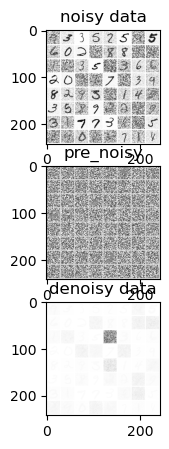

In [12]:
# 生成图像
model.eval()
with torch.no_grad():
    #sample_batch : a batch of images
    sample_batch = next(iter(train_loader))[0].to(device)
    batch_size = sample_batch.size(0)
    t = torch.randint(0, timesteps, (batch_size,), device=device)
    print(t)
    #t = t.view(-1, 1, 1, 1)
    noisy_img, noise = diffusion_model.forward_diffusion(sample_batch, t, timesteps)
    pre_noisy= model(noisy_img)
    denoised_img = diffusion_model.reverse_diffusion(noisy_img,pre_noisy,t,timesteps)

    fig, axs = plt.subplots(3, 1, figsize=(12, 5))
    axs[0].set_title("noisy data")
    axs[0].imshow(torchvision.utils.make_grid(noisy_img)[0].detach().cpu(), cmap="Greys")

    axs[1].set_title("pre_noisy")
    axs[1].imshow(torchvision.utils.make_grid(pre_noisy)[0].detach().cpu(), cmap="Greys")

    axs[2].set_title("denoisy data")
    axs[2].imshow(torchvision.utils.make_grid(denoised_img)[0].detach().cpu(), cmap="Greys")